In [1]:
from PIL import Image
import numpy as np
import math
import cv2
import skimage.measure
import os
from matplotlib import pyplot as plt

In [2]:
# def find_neighbors(x, y, img):
#     left_candidates = []
#     right_candidates = []
#     top_candidates = []
#     bottom_candidates = []
#     for i in range(len(by_x)):
#         if by_x[i][0] <= x and by_x[i+1][0] >= x:
#             left_candidates.append((by_x[i][0], by_x[i][1]))
#         if by_x[i][0] >= x and by_x[i-1][0] <= x:
#             right_candidates.append((by_x[i][0], by_x[i][1]))
#     for i in range(len(by_y)):
#         if by_y[i][1] <= y and by_y[i+1][1] >= y:
#             top_candidates.append((by_y[i][0], by_y[i][1]))
#         if by_y[i][1] >= y and by_y[i-1][1] <= y:
#             bottom_candidates.append((by_y[i][0], by_y[i][1]))
    
#     left_candidates.sort(key = lambda a: abs(a[1] - y))
#     right_candidates.sort(key = lambda a: abs(a[1] - y))
#     top_candidates.sort(key = lambda a: abs(a[0] - x))
#     bottom_candidates.sort(key = lambda a: abs(a[0] - x))

#     neighbors = []
#     for n in [left_candidates, right_candidates, top_candidates, bottom_candidates]:
#         if len(n) == 0:
#             continue
#         n = n[0]
#         neighbors.append(Neighbor(n[0], n[1], img[n[1], n[0]]))
    
#     return neighbors

In [3]:
class Neighbor:
    def __init__(self):
        pass
    def __init__(self, x, y, value):
        self.x = x
        self.y = y
        self.value = value
    def set_location(self, x, y):
        self.x = x
        self.y = y
    def set_value(self, value):
        self.value = value
    
    def __str__(self):
        return f"({self.x}, {self.y}) = {self.value}"

def find_neighbors(x, y, img, max_rad):
    rad = 0
    neighbors = []
    while len(neighbors) < 3 and rad < max_rad:
        rad += 1
        for dx in range(-rad, rad+1):
            dy = rad
            if dx == 0 and dy == 0:
                continue
            if x+dx < 0 or x+dx >= img.shape[0] or y+dy < 0 or y+dy >= img.shape[1]:
                continue
            if img[x+dx, y+dy] != 0:
                n = Neighbor(x = x+dx, y = y+dy, value = img[x+dx, y+dy])
                neighbors.append(n)
        for dx in range(-rad, rad+1):
            dy = -rad
            if dx == 0 and dy == 0:
                continue
            if x+dx < 0 or x+dx >= img.shape[0] or y+dy < 0 or y+dy >= img.shape[1]:
                continue
            if img[x+dx, y+dy] != 0:
                n = Neighbor(x = x+dx, y = y+dy, value = img[x+dx, y+dy])
                neighbors.append(n)
        for dy in range(-rad+1, rad):
            dx = rad
            if dx == 0 and dy == 0:
                continue
            if x+dx < 0 or x+dx >= img.shape[0] or y+dy < 0 or y+dy >= img.shape[1]:
                continue
            if img[x+dx, y+dy] != 0:
                n = Neighbor(x = x+dx, y = y+dy, value = img[x+dx, y+dy])
                neighbors.append(n)
        for dy in range(-rad+1, rad):
            dx = -rad
            if dx == 0 and dy == 0:
                continue
            if x+dx < 0 or x+dx >= img.shape[0] or y+dy < 0 or y+dy >= img.shape[1]:
                continue
            if img[x+dx, y+dy] != 0:
                n = Neighbor(x = x+dx, y = y+dy, value = img[x+dx, y+dy])
                neighbors.append(n)

    return neighbors

def weighted_interpolation(x, y, neighbors):
    numerator = 0
    denominator = 0

    w = lambda d: math.exp(-0.5*d)
    d = lambda x1, y1, x2, y2: math.sqrt((x1-x2)**2 + (y1-y2)**2)

    for n in neighbors:
        distance = d(x, y, n.x, n.y)
        numerator += n.value * w(distance)
        denominator += w(distance)
    
    return numerator / denominator

def fill_pixel(x, y, img, max_rad = 30):
    if img[x, y] == 0:
      neighbors = find_neighbors(x, y, img, max_rad)
      
      # if (np.all([n.y >= y for n in neighbors])):
      #   return 255
      if len(neighbors) == 0:
          return 0
      return weighted_interpolation(x, y, neighbors)
    else:
      return img[x, y]
    
def imresize(im, size, interp='nearest'):
    if interp == 'nearest':
        resample = Image.NEAREST
    elif interp == 'bilinear':
        resample = Image.BILINEAR
    elif interp == 'bicubic':
        resample = Image.BICUBIC
    else:
        raise Exception('resample method undefined!')

    return im.resize(size, resample)

def lin_mapping(vector, max_val = 250):
    distance_scaled = np.interp(vector, [0, max_val], [0, 255]).astype(np.uint8)
    return distance_scaled

def log_mapping(vector, max_val = 250):
    log1p = lambda x: 255 * math.log(x + 1) / math.log(max_val + 1)
    distance_scaled = np.vectorize(log1p)(vector).astype(np.uint8)
    return distance_scaled
    
def densify(img):
    return img
    a = skimage.measure.block_reduce(img, (12, 12), np.max)
    new_img = np.zeros(a.shape, dtype=np.int8)

    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            new_img[i, j] = fill_pixel(i, j, a, max_rad = 3)

    interp = Image.fromarray(new_img, mode="L")
    return imresize(interp, (1920, 1080))

In [4]:
root_dir = f"/Data/dataLIDAR/0221-1817_seed_9876/clear_night"

In [5]:
def to_sparse_depth_image(lidar, w, h):
    VCOORD = 0
    UCOORD = 1
    DISTANCE = 3

    vcoord = lidar[VCOORD].astype(np.uint16)
    ucoord = lidar[UCOORD].astype(np.uint16)

    # distance_cm = (lidar[DISTANCE] * 100).astype(np.uint16)
    distance_scaled = log_mapping(lidar[DISTANCE], 250)
    # distance_scaled = np.interp(lidar[DISTANCE], [0, 250], [0, 255]).astype(np.uint8)

    distance = np.zeros((h, w), dtype=np.uint8)
    distance[vcoord, ucoord] = distance_scaled

    return distance

def test(lidar, rgb, root_dir):
    rgb_arr = np.array(Image.open(os.path.join(root_dir, 'rgb', rgb)).convert('RGB'), dtype = np.uint8)
    lidar_arr = np.load(os.path.join(root_dir, 'lidar_2d', lidar))
    distance = to_sparse_depth_image(lidar_arr, rgb_arr.shape[1], rgb_arr.shape[0])
    distance = densify(distance)
    return distance

result = test('11.npy', '11.png', root_dir)
  # im = skimage.measure.block_reduce(result, (4, 4), np.max)
  # im = Image.fromarray(im)
  # imresize(im, (1920, 1080), interp='nearest')

In [6]:
result

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [7]:
rgb = Image.open(os.path.join(root_dir, 'rgb', '11.png'))

In [8]:
mask = Image.open(os.path.join(root_dir, 'rgb_seg', '11.png'))

In [9]:
def imresize(im, size, interp='bilinear'):
    if interp == 'nearest':
        resample = Image.NEAREST
    elif interp == 'bilinear':
        resample = Image.BILINEAR
    elif interp == 'bicubic':
        resample = Image.BICUBIC
    else:
        raise Exception('resample method undefined!')

    return im.resize(size, resample)

def noise_image(x, y, brightness, channels = 3, courseness = 8):
    rand = np.random.rand(y // courseness, x // courseness, channels).astype(np.float32)
    rand_im = Image.fromarray((rand * brightness).astype(np.uint8))
    return imresize(rand_im, (x, y))

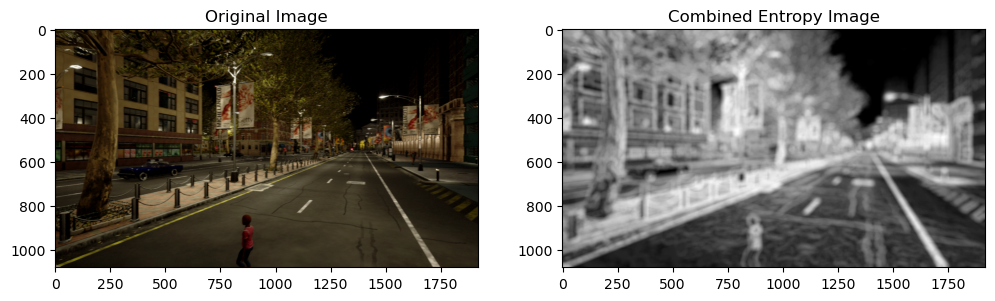

In [10]:
from skimage.util import img_as_ubyte
from skimage.filters.rank import entropy
from skimage.morphology import disk

rgb = np.array(Image.open(os.path.join(root_dir, 'rgb', '11.png')))
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

entropy_r = entropy(rgb[:, :, 0], disk(16))
entropy_g = entropy(rgb[:, :, 1], disk(16))
entropy_b = entropy(rgb[:, :, 2], disk(16))

entropy_combined = np.stack((entropy_r, entropy_g, entropy_b), axis=-1)
entropy_combined = sigmoid(entropy_combined)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(rgb)
ax[0].set_title('Original Image')
ax[1].imshow(entropy_r, cmap='gray')
ax[1].set_title('Combined Entropy Image')
plt.show()

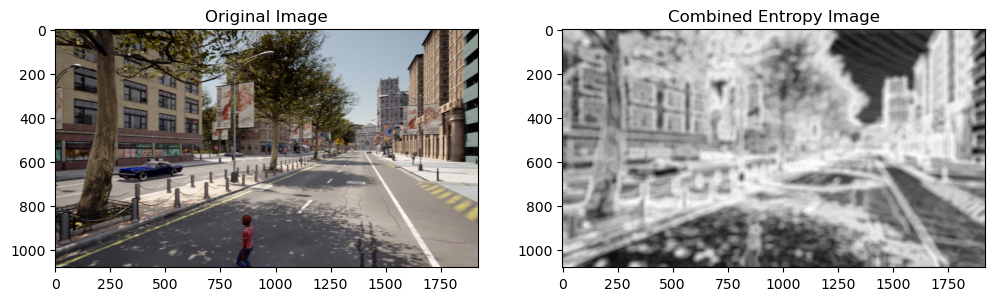

In [11]:
rgb = np.array(Image.open(os.path.join(f"/Data/dataLIDAR/0221-1730_seed_9876/clear_day", 'rgb', '11.png')))
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

entropy_r = entropy(rgb[:, :, 0], disk(16))
entropy_g = entropy(rgb[:, :, 1], disk(16))
entropy_b = entropy(rgb[:, :, 2], disk(16))

entropy_combined = np.stack((entropy_r, entropy_g, entropy_b), axis=-1)
entropy_combined = sigmoid(entropy_combined)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(rgb)
ax[0].set_title('Original Image')
ax[1].imshow(entropy_r, cmap='gray')
ax[1].set_title('Combined Entropy Image')
plt.show()

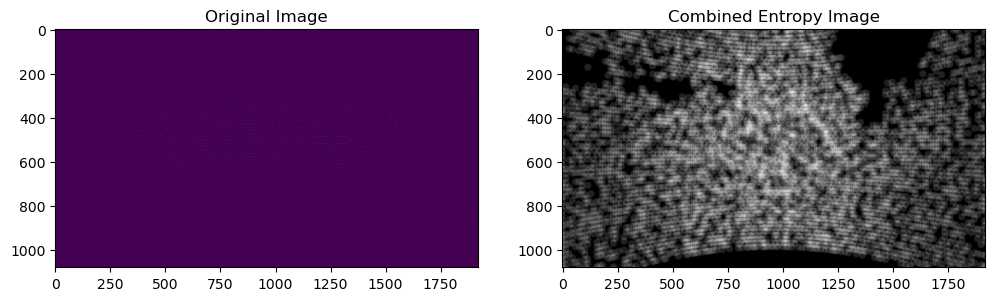

In [12]:
entropy_d = entropy(np.array(result), disk(16))

entropy_d = sigmoid(entropy_d)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(result)
ax[0].set_title('Original Image')
ax[1].imshow(entropy_d, cmap='gray')
ax[1].set_title('Combined Entropy Image')
plt.show()

In [13]:
# Image.fromarray(((entropy_d) * 255).astype(np.uint8), mode = 'L')

In [14]:
def visualize_activation(activation):
  # Select the first activation
  activation_map = activation[0]
  # Normalize 
  activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())

  fig, ax = plt.subplots(8, 12, figsize=(30, 16))
  for i in range(8):
    for j in range(12):
      ax[i, j].imshow(activation_map[i * 12 + j], cmap='viridis')
      ax[i, j].axis('off')
      # plt.savefig(f'activation_map_{i*j}.png')
  
  plt.tight_layout()
  plt.show()

In [15]:
# Image.open('/Data/dataLIDAR/0221-1730_seed_9876/clear_day/rgb/36.png')

In [16]:
a = np.load('c1/features_rgb_23.npy')
# visualize_activation(a)

FileNotFoundError: [Errno 2] No such file or directory: 'c1/features_rgb_23.npy'

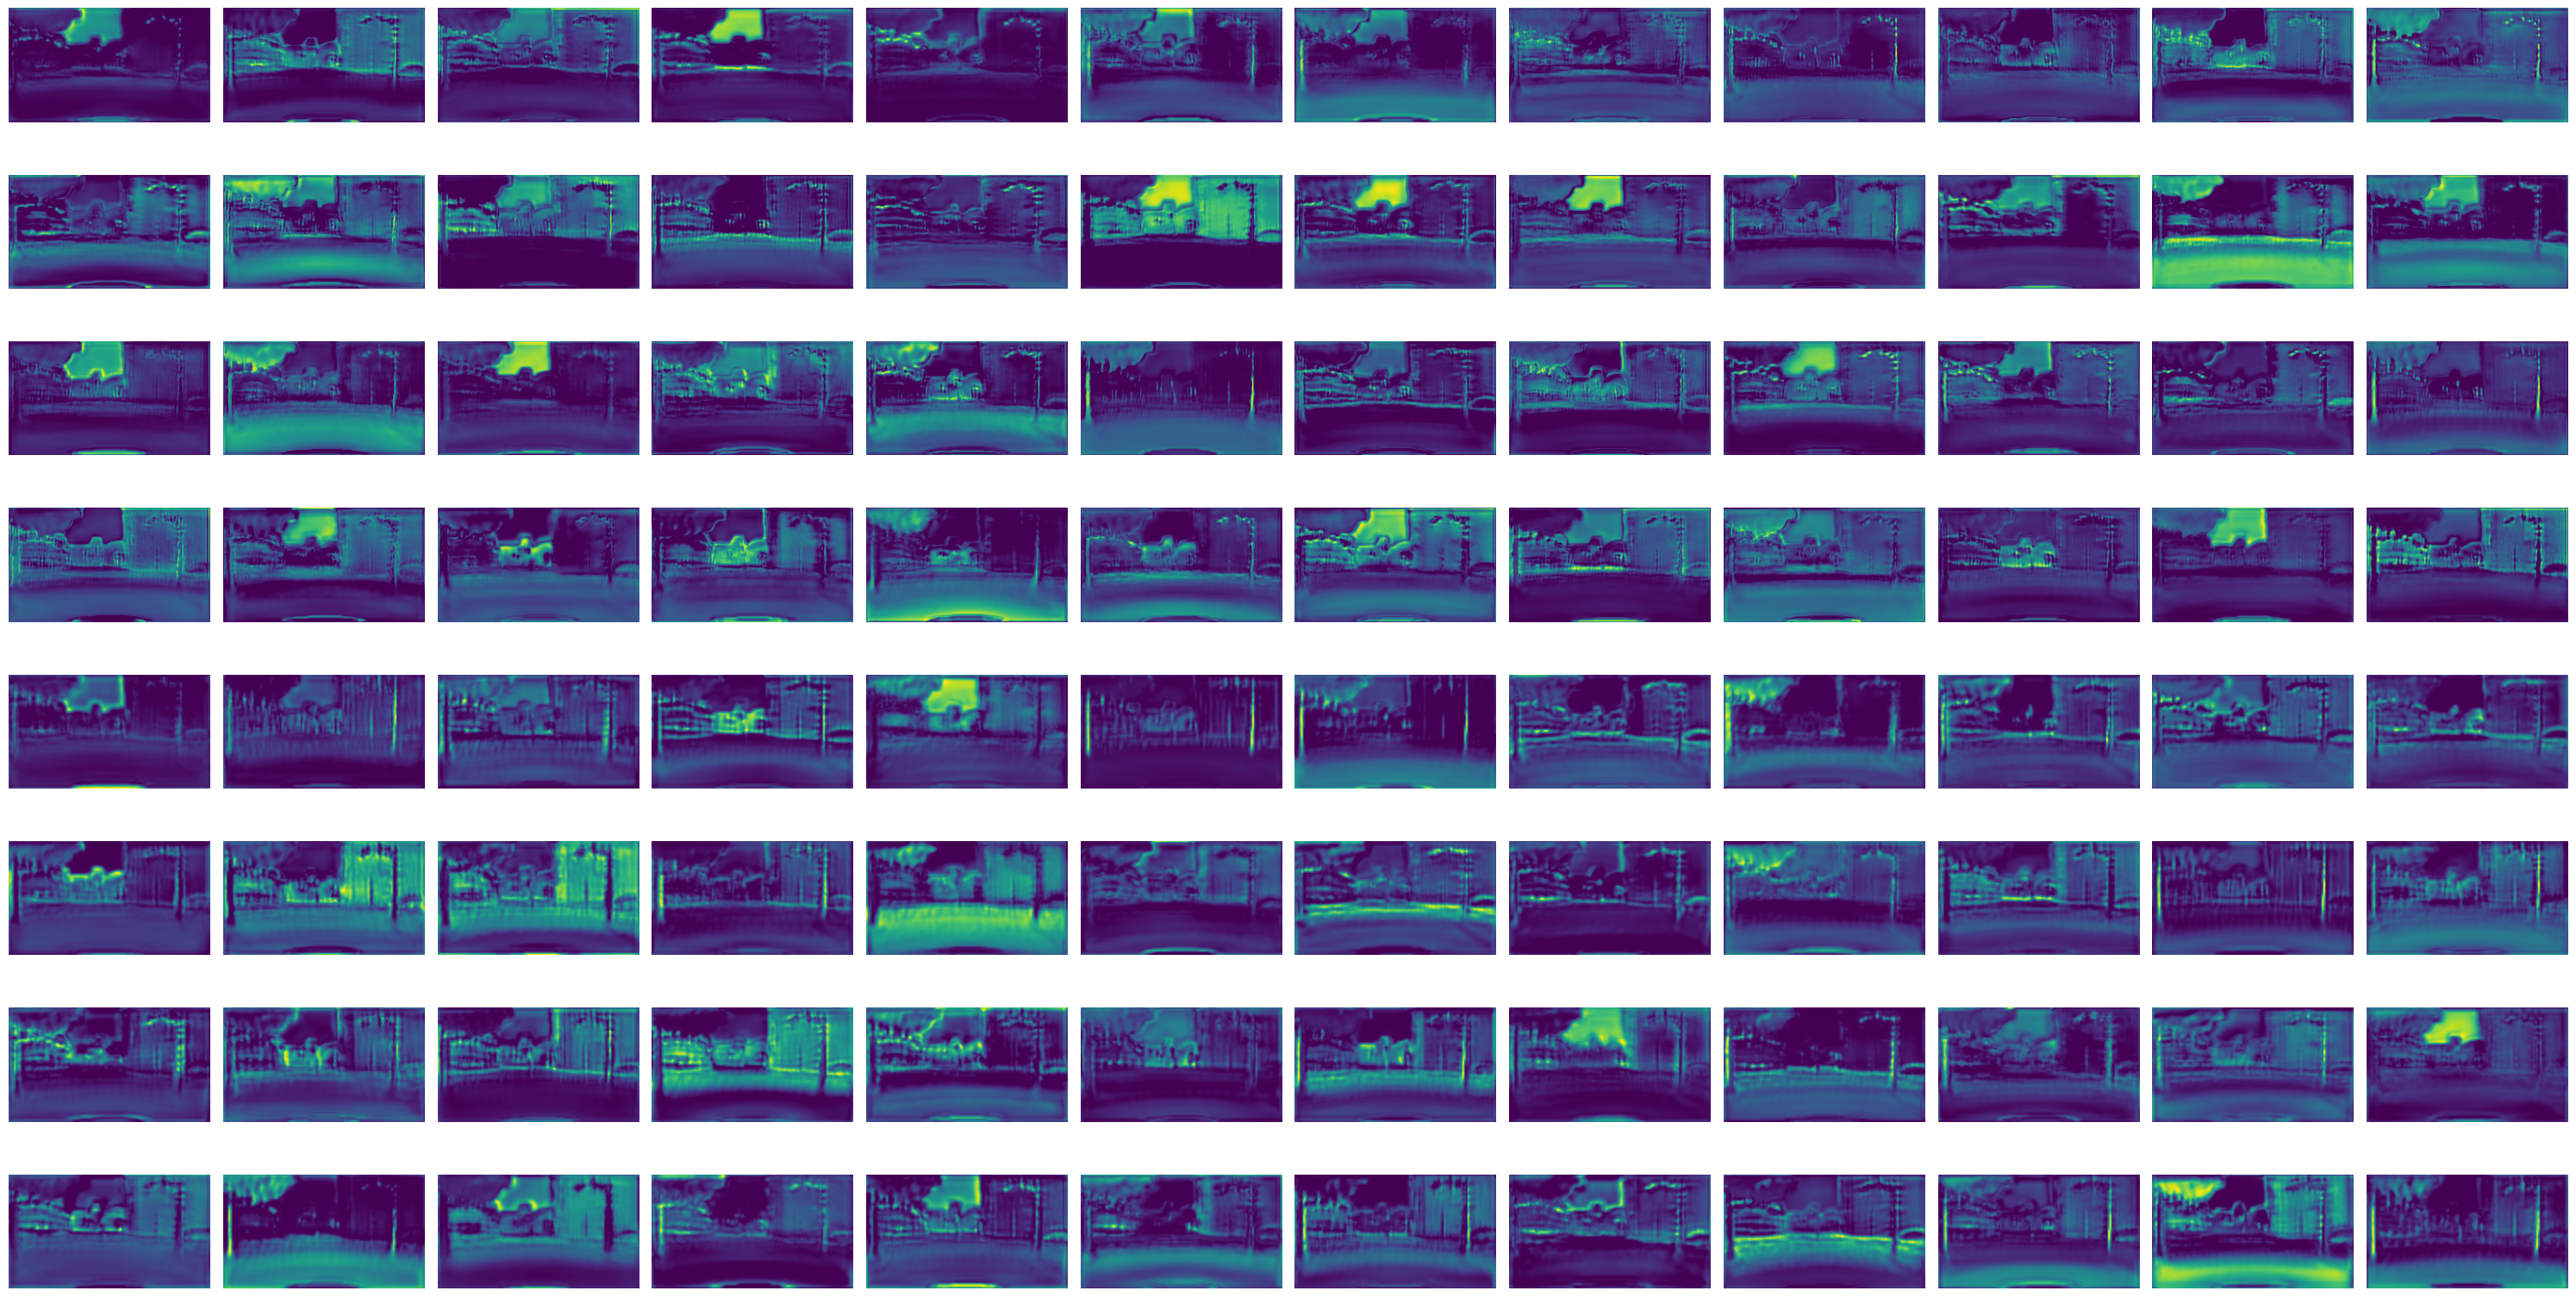

In [ ]:
a = np.load('c1/features_depth_23.npy')
visualize_activation(a)

In [ ]:
a = np.load('n1/features_rgb_0.npy')
# visualize_activation(a)

In [ ]:
# Image.open('/Data/dataLIDAR/0221-1730_seed_9876/clear_day/rgb/320.png')

In [ ]:
# Image.open('/Data/dataLIDAR/0221-1817_seed_9876/clear_night/rgb/320.png')

In [ ]:
screenshot = Image.open('/Data/fusion_out/hrnet_fusion_cleardata/results_20_epochs/904.png')
pred = screenshot.crop((2 * (screenshot.size[0] // 3), 0, screenshot.size[0], screenshot.size[1]))
screenshot = imresize(screenshot, (1920 // 30, 1080 // 30), interp = 'nearest')
screenshot = imresize(screenshot, (1920, 1080), interp = 'nearest')